In [15]:
import numpy as np
import os
import torch

from datetime import datetime
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import transforms

import amphibian.preprocess.preprocessing as preproc

from amphibian.fetch.reader import AmphibianReader
from amphibian.preprocess.train_test_split import TrainTestSplit
from amphibian.architectures import SoftmaxRegressionModel, RNNModel, LSTMModel, AttentionModel
from amphibian.train import SingleTrainer
from amphibian.visual import ConfusionMatrix, MAVI

In [16]:
ar = AmphibianReader('data/all_values/banking',
                     datetime(2010, 7, 16),
                     datetime(2018, 6, 10))

_ = ar.create_torch()

In [17]:
train_test_splits = [TrainTestSplit(ar, input_reg='ASIA_PACIFIC', pred_reg='EMEIA', int_start=0, int_end=ar.torch['AMERICA'].shape[0], train_size=0.9465),
                     TrainTestSplit(ar, input_reg='ASIA_PACIFIC', pred_reg='AMERICA', int_start=0, int_end=ar.torch['AMERICA'].shape[0], train_size=0.9465),
                     TrainTestSplit(ar, input_reg='EMEIA', pred_reg='AMERICA', int_start=0, int_end=ar.torch['AMERICA'].shape[0], train_size=0.9465)]

## RNN

In [18]:
rnn_params = {'learning_rate': 0.003956062, 'batch_size': 32, 'seq_len': 25, 'hidden_size': 8, 'dropout': 0.367072568}
learning_rate = rnn_params.pop('learning_rate')
batch_size = rnn_params['batch_size']
seq_len = rnn_params['seq_len']
model_params = {**rnn_params, 
                **{'input_size': 60,
                   'n_outputs': 3,
                   'num_layers': 2}}
model = RNNModel(**model_params)
model.load_state_dict(torch.load('./data/model_pickles/rnn.pth', map_location=torch.device('cuda:0')))
model.to('cuda')

RNNModel(
  (rnn): RNN(60, 8, num_layers=2, dropout=0.367072568)
  (fc): Linear(in_features=8, out_features=3, bias=True)
)

In [19]:
timeser_datasets = [
    preproc.TimeSeriesDataset(
        tts, int_len=seq_len,
        transform=transforms.Compose([
            preproc.FillNaN(), preproc.Normalizing(),
            preproc.DummyFillNaN(), preproc.Formatting(),
            preproc.FormattingY()
        ])
    )
    for tts in train_test_splits
]

tsds = torch.utils.data.ConcatDataset(timeser_datasets)
vds = torch.utils.data.ConcatDataset(
    [preproc.ValidDataset(td) for td in timeser_datasets]
)

d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
d:\gsn-projekt\venv\lib\site-packages\numpy\lib\nanfunctions.py:1503: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


In [20]:
dl = DataLoader(vds, batch_size=len(vds))
for i, batch in enumerate(dl):
    y_true = batch['test_y'].cpu().numpy()
    model.eval()
    with torch.no_grad():
        y_pred = torch.argmax(model(batch['test_obs'].permute(1, 0, 2)), 1).cpu().numpy()

In [21]:
confmat = confusion_matrix(y_true, y_pred)

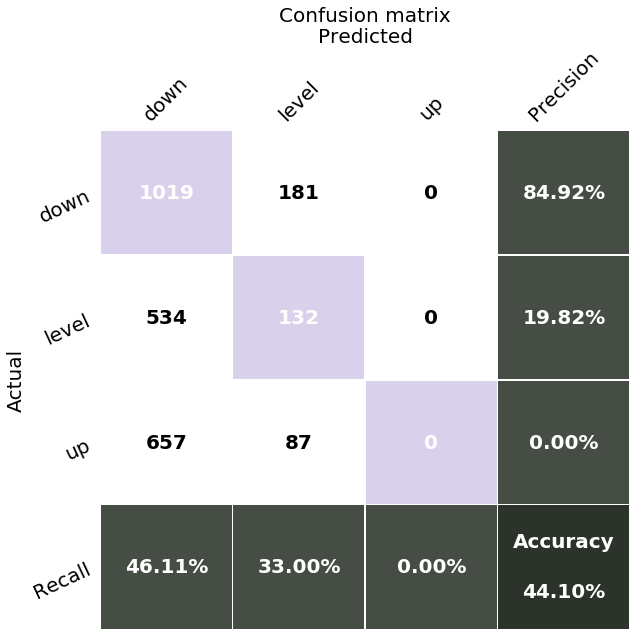

In [22]:
ConfusionMatrix(confmat, ['down', 'level', 'up']).plot(fontsize=20)

In [23]:
dl = DataLoader(vds, batch_size=int(len(vds) / 30))
for i, batch in enumerate(dl):
    print('Region {}'.format(i // 10 + 1))
    print('Company {}'.format((i % 10 + 1)))
    y_true = batch['test_y'].cpu().numpy()
    model.eval()
    with torch.no_grad():
        y_pred = torch.argmax(model(batch['test_obs'].permute(1, 0, 2)), 1).cpu().numpy()
    print(np.sum(y_true == y_pred) / (len(vds) / 30))

Region 1
Company 1
0.27586206896551724
Region 1
Company 2
0.28735632183908044
Region 1
Company 3
0.3218390804597701
Region 1
Company 4
0.3333333333333333
Region 1
Company 5
0.27586206896551724
Region 1
Company 6
0.2988505747126437
Region 1
Company 7
0.2988505747126437
Region 1
Company 8
0.2413793103448276
Region 1
Company 9
0.22988505747126436
Region 1
Company 10
0.2988505747126437
Region 2
Company 1
0.28735632183908044
Region 2
Company 2
0.25287356321839083
Region 2
Company 3
0.25287356321839083
Region 2
Company 4
0.25287356321839083
Region 2
Company 5
0.3793103448275862
Region 2
Company 6
0.2988505747126437
Region 2
Company 7
0.22988505747126436
Region 2
Company 8
0.26436781609195403
Region 2
Company 9
0.28735632183908044
Region 2
Company 10
0.26436781609195403
Region 3
Company 1
0.7471264367816092
Region 3
Company 2
0.8045977011494253
Region 3
Company 3
0.7241379310344828
Region 3
Company 4
0.7471264367816092
Region 3
Company 5
0.7701149425287356
Region 3
Company 6
0.839080459770114